In [6]:

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import optuna
import numpy as np
import pandas as pd
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Análisis de la serie de tiempo con la variable ocupados del dataset de Empleo en Colombia desde el 2001-01 hasta el 2019-06.

In [7]:
#Lectura del archivo excel con los datos de empleo en Colombia
data = pd.read_excel("../Sesion1/datosEmpleo.xlsx", index_col='mes',parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


In [8]:
serie = data['Ocupados']
serie 

mes
2001-01-01     6923.604
2001-02-01     7037.746
2001-03-01     6945.973
2001-04-01     6973.079
2001-05-01     6994.462
                ...    
2019-02-01    10557.917
2019-03-01    10760.776
2019-04-01    10632.028
2019-05-01    10813.000
2019-06-01    10848.000
Name: Ocupados, Length: 222, dtype: float64

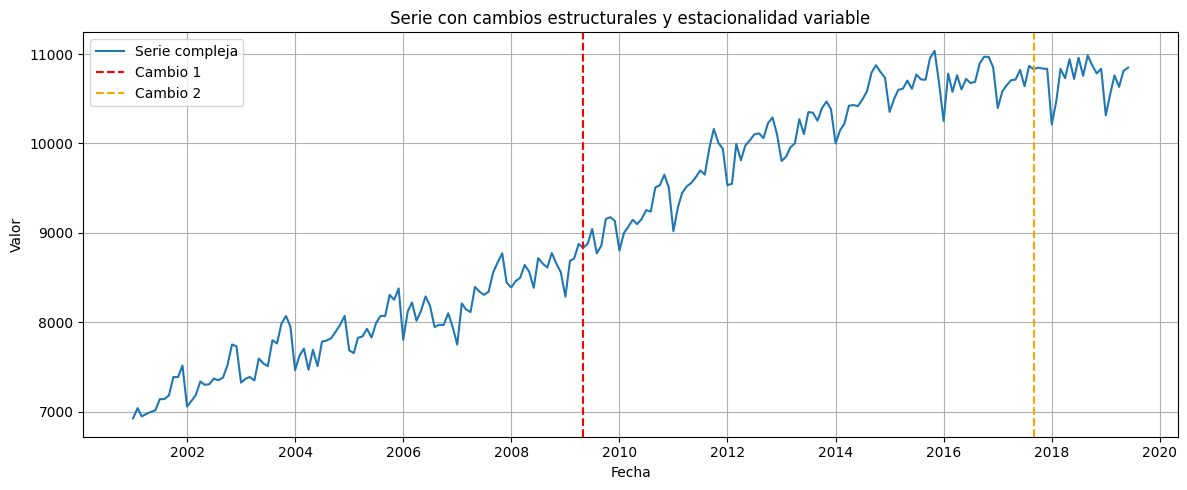

In [9]:
plt.figure(figsize=(12, 5))
plt.plot(serie, label="Serie compleja")
plt.axvline(serie.index[100], color='red', linestyle='--', label="Cambio 1")
plt.axvline(serie.index[200], color='orange', linestyle='--', label="Cambio 2")
plt.title("Serie con cambios estructurales y estacionalidad variable")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

def evaluar_expanding_forecast(serie, order, window=12, step_size=1, horizon=1, metric='rmse'):
    """
    Simula pronósticos autoregresivos en tiempo real con ventana expandida desde el inicio.
    
    Parámetros:
        serie     : serie temporal (pd.Series)
        order     : tupla ARIMA (p,d,q)
        window    : cantidad de pronósticos (desde el final hacia atrás)
        step_size : cada cuántos puntos se hace un pronóstico
        horizon   : cuántos pasos adelante predices en cada punto
        metric    : 'rmse' o 'mae'

    Retorna:
        Error promedio global (RMSE o MAE) entre todos los valores predichos vs observados.
    """
    n = len(serie)
    predichos = []
    observados = []

    puntos_finales = list(range(n - window * step_size, n - horizon + 1, step_size))

    for end_train in puntos_finales:
        train = serie[:end_train]
        test = serie[end_train:end_train + horizon]

        if len(test) < horizon:
            continue

        try:
            model = ARIMA(train, order=order, enforce_stationarity=False, enforce_invertibility=False).fit()
            pred = model.forecast(steps=horizon)

            predichos.extend(pred)
            observados.extend(test)

        except:
            continue

    if len(predichos) == 0:
        return np.inf

    predichos = np.array(predichos)
    observados = np.array(observados)

    if metric == 'rmse':
        return np.sqrt(mean_squared_error(observados, predichos))
    elif metric == 'mae':
        return np.mean(np.abs(observados - predichos))
    else:
        raise ValueError("Metric must be 'rmse' or 'mae'")


In [11]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

def objective(trial):
    
    p = trial.suggest_int("p", 1, 10)
    d = trial.suggest_int("d", 1, 3)
    q = trial.suggest_int("q", 1, 10)
    
    order = (p, d, q)
    return evaluar_expanding_forecast(serie, order, window=12, step_size=1, horizon=2)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20,  )

[I 2025-11-23 10:01:27,324] A new study created in memory with name: no-name-9f08ceaa-ed0d-4ac3-b024-3d2a8febba8d
[I 2025-11-23 10:01:32,742] Trial 0 finished with value: 181.81426927455445 and parameters: {'p': 6, 'd': 3, 'q': 8}. Best is trial 0 with value: 181.81426927455445.
[I 2025-11-23 10:01:37,208] Trial 1 finished with value: 164.8261284373193 and parameters: {'p': 5, 'd': 1, 'q': 7}. Best is trial 1 with value: 164.8261284373193.
[I 2025-11-23 10:01:41,699] Trial 2 finished with value: 261.44430267488883 and parameters: {'p': 10, 'd': 3, 'q': 2}. Best is trial 1 with value: 164.8261284373193.
[I 2025-11-23 10:01:42,529] Trial 3 finished with value: 341.7366630601627 and parameters: {'p': 1, 'd': 3, 'q': 1}. Best is trial 1 with value: 164.8261284373193.
[I 2025-11-23 10:01:47,732] Trial 4 finished with value: 220.81920792779167 and parameters: {'p': 9, 'd': 3, 'q': 4}. Best is trial 1 with value: 164.8261284373193.
[I 2025-11-23 10:01:53,539] Trial 5 finished with value: 195.

In [12]:
#Genera la visualización de los resultados del estudio
optuna.visualization.plot_optimization_history(study)


## Taller en Clase: Pronóstico del Número de Ocupados
### Objetivo del taller:

Empleando la información del número de ocupados (en miles de personas) para las 13 principales ciudades del país, construya un modelo de pronóstico para los próximos 6 meses utilizando los métodos de suavización exponencial vistos en clase, considerando versiones aditivas o multiplicativas según la naturaleza de la serie. Para ajustar los hiperparámetros del modelo (como alpha, beta y gamma), utilice optimización bayesiana a través de la librería Optuna, definiendo un espacio de búsqueda adecuado. La evaluación del modelo debe realizarse mediante un protocolo de validación temporal, utilizando una ventana móvil o recursiva, y empleando métricas apropiadas como RMSE.

Una vez ajustado el modelo, compárelo con el mejor modelo obtenido en el ejercicio anterior. Luego, elabore un informe breve (máximo una página de texto) explicando  los resultados obtenidos y las proyecciones generadas, incluyendo las predicciones para los próximos 6 meses, mencione las principales limitaciones del pronóstico.

